In [ ]:
!pip install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torchvision import models

In [ ]:
vgg = models.vgg19(pretrained = True)
vgg

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [ ]:
for parameters in vgg.parameters():
    parameters.require_grad = False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
vgg.to(device)

In [ ]:
from PIL import Image
from torchvision import transforms as T

In [ ]:
def preprocess(img_path, max_size = 512):
    image = Image.open(img_path).convert('RGB')
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    img_transforms = T.Compose([T.Resize(size), T.ToTensor(), T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])])
    image = img_transforms(image)
    image = image.unsqueeze(0)
    return image

In [ ]:
content_p = preprocess('/content/content.jpg')
style_p = preprocess('/content/style.jpg')

content_p = content_p.to(device, torch.float)
style_p = style_p.to(device, torch.float)
assert style_p.size() == content_p.size(), \
    "we need to import style and content images of the same size"


In [ ]:
# deprocessing image

import numpy as np
import matplotlib.pyplot as plt


In [ ]:

def deprocess(tensor):
    image = tensor.to('cpu').clone()
    image = image.numpy()
    image = image.squeeze(0)
    image = image.transpose(1, 2, 0)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = image.clip(0, 1)
    return image

In [ ]:
content_d = deprocess(content_p)
style_d = deprocess(style_p)

print("Deprocess content: ", content_d.shape)
print("Deprocess style:", style_d.shape)

Deprocess content:  (512, 682, 3)
Deprocess style: (512, 682, 3)


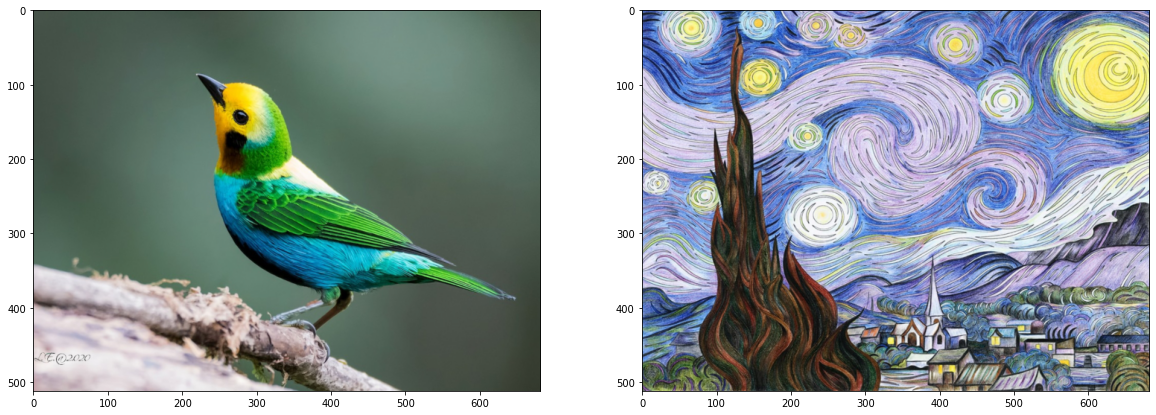

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))

ax1.imshow(content_d)
ax2.imshow(style_d)


In [ ]:
def get_features(image, model, layers=None):
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

In [ ]:
def gram_matrix(tensor):
    
    _, d, h, w = tensor.size()
    
    tensor = tensor.view(d, h * w)
    
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [ ]:
content_features = get_features(content_p, vgg)
style_features = get_features(style_p, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}
target = content_features.clone().requires_grad_(True).to(device)


RuntimeError: ignored

In [ ]:
style_grams = {layer : gram_matrix(style_f[layer]) for layer in style_f}

NameError: ignored